## Generate Power-Grid

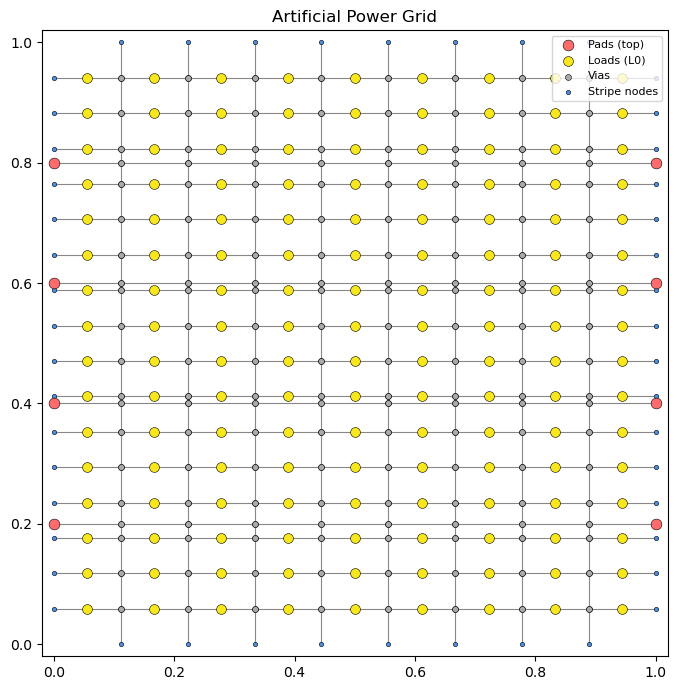

Graph: 520 nodes, 652 edges
Loads placed: 144 nodes; Pads: 8


In [1]:
from generate_power_grid import generate_power_grid

G, loads, pads = generate_power_grid(
    K=3,
    N0=16,
    I_N=1000,
    N_vsrc=8,
    max_stripe_res=5.0,   # Ω per stripe in layer 0
    max_via_res=0.1,      # Ω for vias between L0-L1; halves on higher vias
    load_current=1.0,
    seed=7,
    plot=True,
)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Loads placed: {len(loads)} nodes; Pads: {len(pads)}")

In [2]:
from irdrop import PowerGridModel, StimulusGenerator, IRDropSolver

# Build model (pads at 1.0V)
model = PowerGridModel(G, pad_nodes=pads, vdd=1.0)

/home/patrasej/workspace_dev2/local/miniconda3/envs/pyspice/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:573: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format',


In [3]:
# Stimulus generator using discovered load nodes
stim_gen = StimulusGenerator(load_nodes=list(loads.keys()), vdd=1.0, seed=7, graph=G)

In [4]:
stimulus_area = (0.4, 0.4, 0.6, 0.6)
x1,y1,x2,y2 = stimulus_area
inside = []
for n in loads:
    x,y = G.nodes[n]['xy']
    if x1 <= x <= x2 and y1 <= y <= y2:
        inside.append((n,x,y))
inside, len(inside)

([(NodeID(layer=0, idx=218), 0.5, 0.4117647058823529),
  (NodeID(layer=0, idx=227), 0.5, 0.47058823529411764),
  (NodeID(layer=0, idx=236), 0.5, 0.5294117647058824),
  (NodeID(layer=0, idx=245), 0.5, 0.5882352941176471)],
 4)

In [5]:
meta = stim_gen.generate(1., count=1, distribution="gaussian", gaussian_loc=1.0, gaussian_scale=0.2, area=stimulus_area)
solver = IRDropSolver(model)
result = solver.solve(meta.currents, meta)

In [24]:
current_nodes = [n for n in meta.currents.keys()]
current_nodes

[NodeID(layer=0, idx=236)]

In [27]:
# Show ir-drop at meta.currents nodes
[1.0 - result.voltages[n] for n in meta.currents.keys()]

[0.27935509860410357]

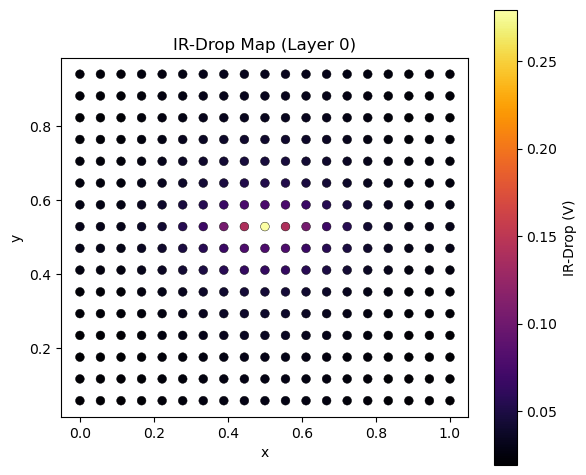

In [21]:
from IPython.display import display
from irdrop import plot_ir_drop_map
# Corrected call: pass vdd as numeric (1.0) and optionally layer=0
fig, ax = plot_ir_drop_map(G, result.voltages, vdd=1.0, layer=0)
display(fig)

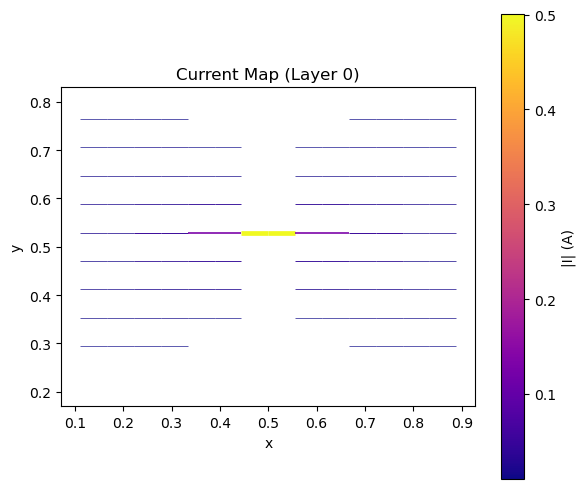

In [22]:
from irdrop import plot_current_map
fig, ax = plot_current_map(G, result.voltages, layer=0, min_current=1.e-2, show=True)
display(fig)

## Effective Resistance Computation

Compute effective resistance between node pairs using the `EffectiveResistanceCalculator`.

In [25]:
from irdrop import EffectiveResistanceCalculator
import numpy as np

# Create calculator using the existing model
calc = EffectiveResistanceCalculator(model)

# Get some load nodes to test
load_nodes = current_nodes + list(loads.keys())[:10]
print(f"Testing with {len(load_nodes)} load nodes")

Testing with 11 load nodes


In [26]:
# Example 1: Compute R_eff from nodes to ground (pads)
ground_pairs = [(node, None) for node in load_nodes]
reff_to_ground = calc.compute_batch(ground_pairs)

print("Effective resistance to ground (first 5):")
for i in range(5):
    print(f"  {load_nodes[i]}: {reff_to_ground[i]:.6f} Ω")
    
print(f"\nStatistics:")
print(f"  Min: {np.min(reff_to_ground):.6f} Ω")
print(f"  Max: {np.max(reff_to_ground):.6f} Ω")
print(f"  Mean: {np.mean(reff_to_ground):.6f} Ω")

Effective resistance to ground (first 5):
  NodeID(layer=0, idx=236): 0.279355 Ω
  NodeID(layer=0, idx=160): 0.637724 Ω
  NodeID(layer=0, idx=161): 0.392620 Ω
  NodeID(layer=0, idx=162): 0.362060 Ω
  NodeID(layer=0, idx=163): 0.358665 Ω

Statistics:
  Min: 0.279355 Ω
  Max: 0.637724 Ω
  Mean: 0.428787 Ω


In [28]:
# Example 2: Compute R_eff between pairs of nodes
node_pairs = [(load_nodes[i], load_nodes[i+1]) for i in range(5)]
reff_pairs = calc.compute_batch(node_pairs)

print("Effective resistance between node pairs:")
for i, (u, v) in enumerate(node_pairs):
    print(f"  {u} ↔ {v}: {reff_pairs[i]:.6f} Ω")

Effective resistance between node pairs:
  NodeID(layer=0, idx=236) ↔ NodeID(layer=0, idx=160): 0.875586 Ω
  NodeID(layer=0, idx=160) ↔ NodeID(layer=0, idx=161): 0.490964 Ω
  NodeID(layer=0, idx=161) ↔ NodeID(layer=0, idx=162): 0.385666 Ω
  NodeID(layer=0, idx=162) ↔ NodeID(layer=0, idx=163): 0.375264 Ω
  NodeID(layer=0, idx=163) ↔ NodeID(layer=0, idx=164): 0.373643 Ω


In [29]:
# Example 3: Mixed batch - combine ground and node-to-node pairs
mixed_pairs = [
    (load_nodes[0], None),           # to ground
    (load_nodes[1], load_nodes[2]),  # node-to-node
    (load_nodes[3], None),           # to ground
    (load_nodes[4], load_nodes[5]),  # node-to-node
]
reff_mixed = calc.compute_batch(mixed_pairs)

print("Mixed batch results:")
for i, (u, v) in enumerate(mixed_pairs):
    if v is None:
        print(f"  {u} → ground: {reff_mixed[i]:.6f} Ω")
    else:
        print(f"  {u} ↔ {v}: {reff_mixed[i]:.6f} Ω")

Mixed batch results:
  NodeID(layer=0, idx=236) → ground: 0.279355 Ω
  NodeID(layer=0, idx=160) ↔ NodeID(layer=0, idx=161): 0.490964 Ω
  NodeID(layer=0, idx=162) → ground: 0.362060 Ω
  NodeID(layer=0, idx=163) ↔ NodeID(layer=0, idx=164): 0.373643 Ω
